# Low & High Income Citizen Classification

## Nearest Neighbor KNN 
> ### Author: Lu (Christina) Jin

# Setup: Import all libraries

In [1]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as scipy
import warnings

import statsmodels.api as sm
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from math import sqrt
from matplotlib.ticker import PercentFormatter
from scipy import stats
from pylab import rcParams
rcParams['figure.figsize'] = (20, 10)
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')

# Acquiring Dataset 

In [2]:
# Read data
census_path = r'C:\Users\Lu_ki\OneDrive - Northeastern University\Data Analytics Case Study Projects\Jupyter Notebook\Data Input\citizen-income-adult-all.csv'
census = pd.read_csv(census_path)
census

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48837,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48838,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48839,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


# Perform Basic Data Cleaning

>**I've noticed that since this original dataset does not have column names, so when loading the data, the first row of data entry has been placed as the title. So I'm going to fix that first by adding an additional row, shifting everything down and then adding the column names afterwards. This case we won't loose the first data entry either.**

In [3]:
census.loc[-1,:] = census.columns
census.index += 1
census.sort_index(inplace = True)
census.columns = ['age','workclass','code','education','educational_num',
                  'marital_status','occupation','relationship','race',
                  'gender','capital_gain','capital_loss','weekly_hour',
                  'native_country','income']
census

,age,workclass,code,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,weekly_hour,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


>**I've noticed that there are some cells with unknown values - "?". Since there isn't a whole lot, and also many missing cells are catagorical values, it's hard to replace those with average or mode. So I decided to get rid of all the unknown data in this step.**

In [4]:
# changing all unknown values (?) to NAs
temp = census.replace('?',np.NaN)
temp = temp.dropna(axis=0)
census = temp.reset_index(drop=True)
census

,age,workclass,code,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,weekly_hour,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
45218,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
45219,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
45220,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [5]:
# running a summary of the dataset
census.describe()

,age,workclass,code,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,weekly_hour,native_country,income
count,45222.0,45222,45222.0,45222,45222.0,45222,45222,45222,45222,45222,45222.0,45222.0,45222.0,45222,45222
unique,75.0,7,26741.0,16,17.0,7,14,6,5,2,122.0,98.0,97.0,41,2
top,36.0,Private,203488.0,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
freq,1283.0,33307,21.0,14783,14783.0,21055,6020,18666,38903,30527,41432.0,43081.0,21357.0,41292,34014


>**Looks like the 'income' column we are trying to classify has only 2 unique values: <=50K and >50K, with 34014 out of 45222 being "<=50K". Only 2 unique values also implies that we could put them in binary formats of 1 and 0.** 

In [6]:
census['income'] = (census['income'] == (">50K")).astype(int)
census['income']
census['income'].describe()

count    45222.000000
mean         0.247844
std          0.431766
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: income, dtype: float64

>**Same with the gender column.** 

In [7]:
census['gender'] = (census['gender'] == ("Male")).astype(int)
census['gender']
census['gender'].describe()

count    45222.000000
mean         0.675048
std          0.468362
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

In [8]:
census

,age,workclass,code,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,weekly_hour,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,1,0,0,40,United-States,0
45218,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,0,0,0,36,United-States,0
45219,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,1,0,0,50,United-States,0
45220,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,1,5455,0,40,United-States,0


# Check Correlation Between Each Feature and the Income

In [9]:
census.dtypes

age                object
workclass          object
code               object
education          object
educational_num    object
marital_status     object
occupation         object
relationship       object
race               object
gender              int32
capital_gain       object
capital_loss       object
weekly_hour        object
native_country     object
income              int32
dtype: object

>**After checking the type of all census dataset are assigned to object type of datas. So next, I would be able to change some of the numerical values from object type to numerical type.**

In [21]:
census[["age","code","educational_num","gender","capital_gain",
        "capital_loss","weekly_hour", "income"]] = census[["age","code","educational_num","gender",
                                                           "capital_gain","capital_loss",
                                                           "weekly_hour", "income"]].apply(pd.to_numeric)

census.dtypes

age                float64
workclass           object
code               float64
education           object
educational_num    float64
marital_status      object
occupation          object
relationship        object
race                object
gender               int32
capital_gain       float64
capital_loss       float64
weekly_hour        float64
native_country      object
income               int32
dtype: object

>**Now our census dataset contains both numerical values and strings. So I would like to subset the data into two with one only containing numerical values and the other subset only containing strings, just to make it easier for exploring the correlation between each feature and income.** 

In [26]:
cataColumns = ['workclass','education','marital_status','occupation','relationship','race','native_country']
numColumns = ["age","educational_num","gender","capital_gain","capital_loss","weekly_hour", "income"]

census_num = census[numColumns]
census_cata = census[cataColumns]

census_cata
census_num

,age,educational_num,gender,capital_gain,capital_loss,weekly_hour,income
0,39.0,13.0,1,2174.0,0.0,40.0,0
1,50.0,13.0,1,0.0,0.0,13.0,0
2,38.0,9.0,1,0.0,0.0,40.0,0
3,53.0,7.0,1,0.0,0.0,40.0,0
4,28.0,13.0,0,0.0,0.0,40.0,0
...,...,...,...,...,...,...,...
45217,33.0,13.0,1,0.0,0.0,40.0,0
45218,39.0,13.0,0,0.0,0.0,36.0,0
45219,38.0,13.0,1,0.0,0.0,50.0,0
45220,44.0,13.0,1,5455.0,0.0,40.0,0


>**Next step, I'm going to figure out the significance of each numercial features to the income. This step will be achieved by plotting out a correlation heat map.**

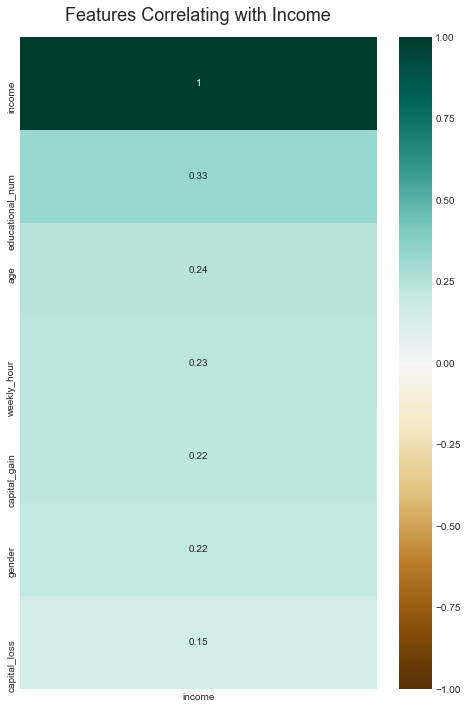

In [23]:
census_num.corr()[['income']].sort_values(by='income', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(census_num.corr()[['income']].sort_values(by='income', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Income', fontdict={'fontsize':18}, pad=16);

>**And following this, I'm going to investigate the significance of each catagorical features to the income. This step will be achieved by first creating dummy variables for all catagorical variables then get a correlation matrix.**

In [30]:
census_cata = pd.get_dummies(census_cata)
census_cata['income'] = census["income"]

census_cata.describe()

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,income
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,...,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.031091,0.068551,0.736522,0.036398,0.083941,0.043032,0.000464,0.027044,0.035801,0.012759,...,0.003870,0.000442,0.002233,0.001216,0.000641,0.000575,0.913095,0.001835,0.000509,0.247844
std,0.173566,0.252691,0.440524,0.187281,0.277303,0.202932,0.021545,0.162214,0.185796,0.112235,...,0.062088,0.021026,0.047207,0.034854,0.025316,0.023971,0.281698,0.042803,0.022547,0.431766
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


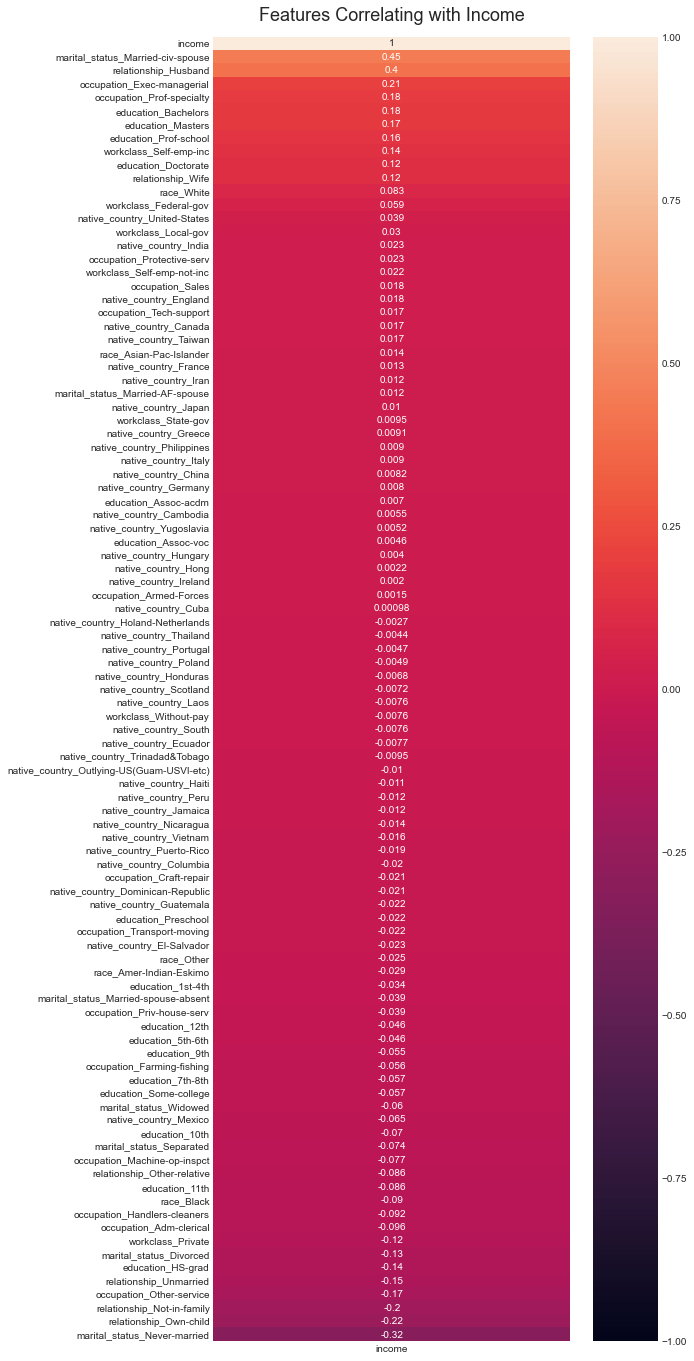

In [37]:
# correlation plot
census_cata.corr()[['income']].sort_values(by='income', ascending=False)
plt.figure(figsize=(8, 24))
heatmap = sns.heatmap(census_cata.corr()[['income']].sort_values(by='income', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='rocket')
heatmap.set_title('Features Correlating with Income', fontdict={'fontsize':18}, pad=16);

# Prep Dataset for Nearest Neighbor (KNN) Model 

In [49]:
factorColumns = ["age","educational_num","gender","capital_gain","capital_loss","weekly_hour"]
target = ['income']

census_key = census[factorColumns]
census_target = census[target]

census_key

,age,educational_num,gender,capital_gain,capital_loss,weekly_hour
0,39.0,13.0,1,2174.0,0.0,40.0
1,50.0,13.0,1,0.0,0.0,13.0
2,38.0,9.0,1,0.0,0.0,40.0
3,53.0,7.0,1,0.0,0.0,40.0
4,28.0,13.0,0,0.0,0.0,40.0
...,...,...,...,...,...,...
45217,33.0,13.0,1,0.0,0.0,40.0
45218,39.0,13.0,0,0.0,0.0,36.0
45219,38.0,13.0,1,0.0,0.0,50.0
45220,44.0,13.0,1,5455.0,0.0,40.0


>**Now we have dataset to work with ready, next is it split it into train and test sets.**

In [50]:
# split data into train and test sets

key_train, key_test, target_train, target_test = train_test_split(census_key, census_target, 
                                                                  test_size=0.3, random_state=42)

# Applying and Testing KNN Model

In [51]:
# create a knn model
KNN_model = KNeighborsClassifier(n_neighbors=5)
warnings.filterwarnings("ignore")

# get a series of 20 scores for the model
score = cross_val_score(KNN_model, key_train, target_train, cv=15)
score

array([0.82472762, 0.8185694 , 0.83088584, 0.82946471, 0.82851729,
       0.83601896, 0.82037915, 0.80663507, 0.83175355, 0.81516588,
       0.82890995, 0.83270142, 0.82180095, 0.81943128, 0.83033175])

In [52]:
# fit the model with train data
KNN_model.fit(key_train, target_train)

# get prediction for income with knn model
target_predict = KNN_model.predict(key_test)
#warnings.filterwarnings("ignore") 

print(target_test)
print(target_predict)

       income
20084       1
20027       0
39505       0
39534       0
12586       1
...       ...
34451       0
21928       0
18106       0
31496       0
37077       0

[13567 rows x 1 columns]
[0 0 0 ... 0 0 0]


In [53]:
# get accuracy score for the model
metrics.accuracy_score(target_test, target_predict)

0.8267118744011204

# Refine Dataset

>**I've noticed that there are a couple of catagorical features are also quite significant in making an impact on the level of income. Thus, I decided to refine my dataset to include those variables and re-run the model, see if there is any improvement in the model performance.**

In [54]:
census_key['is_married_civ_spouse'] = census_cata['marital_status_Married-civ-spouse']
census_key['is_husband'] = census_cata['relationship_Husband']
census_key['is_exec_manager'] = census_cata['occupation_Exec-managerial']
census_key['is_husband'] = census_cata['relationship_Husband']
census_key['is_never_married'] = census_cata['marital_status_Never-married']
census_key['is_own_child'] = census_cata['relationship_Own-child']

census_key

,age,educational_num,gender,capital_gain,capital_loss,weekly_hour,is_married_civ_spouse,is_husband,is_exec_manager,is_never_married,is_own_child
0,39.0,13.0,1,2174.0,0.0,40.0,0,0,0,1,0
1,50.0,13.0,1,0.0,0.0,13.0,1,1,1,0,0
2,38.0,9.0,1,0.0,0.0,40.0,0,0,0,0,0
3,53.0,7.0,1,0.0,0.0,40.0,1,1,0,0,0
4,28.0,13.0,0,0.0,0.0,40.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
45217,33.0,13.0,1,0.0,0.0,40.0,0,0,0,1,1
45218,39.0,13.0,0,0.0,0.0,36.0,0,0,0,0,0
45219,38.0,13.0,1,0.0,0.0,50.0,1,1,0,0,0
45220,44.0,13.0,1,5455.0,0.0,40.0,0,0,0,0,1


In [62]:
# split data into train and test sets, again

key_train, key_test, target_train, target_test = train_test_split(census_key, census_target, 
                                                                  test_size=0.3, random_state=42)

# Re-run the KNN Model

In [59]:
# create a knn model
KNN_model = KNeighborsClassifier(n_neighbors=5)
warnings.filterwarnings("ignore")

# get a series of 20 scores for the model
score = cross_val_score(KNN_model, key_train, target_train, cv=15)
score

array([0.84651824, 0.84509711, 0.84557082, 0.84699195, 0.8446234 ,
       0.84881517, 0.83933649, 0.84075829, 0.84549763, 0.83364929,
       0.83838863, 0.84549763, 0.84834123, 0.84170616, 0.8464455 ])

In [63]:
# fit the model with train data
KNN_model.fit(key_train, target_train)

# get prediction for income with knn model
target_pred = KNN_model.predict(key_test)
#warnings.filterwarnings("ignore") 

print(target_test)
print(target_pred)

       income
20084       1
20027       0
39505       0
39534       0
12586       1
...       ...
34451       0
21928       0
18106       0
31496       0
37077       0

[13567 rows x 1 columns]
[1 0 0 ... 0 0 0]


In [64]:
# get accuracy score for the model
metrics.accuracy_score(target_test, target_pred)

0.8458023144394486

>**The result of model accuracy proved that those catagorical features I have added were pretty significant. Even with everthing else controlled, the model accuracy still increase by 2%, and the classification ability has also improved as seen from the comparison between the acutal and the predictions.**

# Selecting Best Number of Neighbor (K) Value

In [66]:
# set up algorithm for testing 50 different value of Neighbors
num_K=50
mean_score = np.zeros((num_K-1))
std_score = np.zeros((num_K-1))

# get for loop
for i in range(1,num_K):
    KNN_model_test = KNeighborsClassifier(n_neighbors = i).fit(key_train,target_train)
    target_pred = KNN_model_test.predict(key_test)
    mean_score[i-1] = metrics.accuracy_score(target_test,target_pred)
    #std_score[i-1] = np.std(target_pred==target_test)/np.sqrt(target_pred.shape[0])
    
mean_score

array([0.81823542, 0.84064274, 0.83791553, 0.84447557, 0.84580231,
       0.84786615, 0.84823469, 0.8501511 , 0.84904548, 0.84735019,
       0.84823469, 0.84823469, 0.84882435, 0.8501511 , 0.85044593,
       0.85007739, 0.84941402, 0.84978256, 0.85000369, 0.85066706,
       0.85074077, 0.85177268, 0.85177268, 0.85140414, 0.85096189,
       0.85044593, 0.85059335, 0.8501511 , 0.85066706, 0.85140414,
       0.85081448, 0.84956144, 0.84919289, 0.8501511 , 0.84808727,
       0.84911919, 0.84875064, 0.8483821 , 0.85155156, 0.84904548,
       0.84919289, 0.84867694, 0.84852952, 0.8483084 , 0.84757131,
       0.84771873, 0.84646569, 0.84580231, 0.84528636])

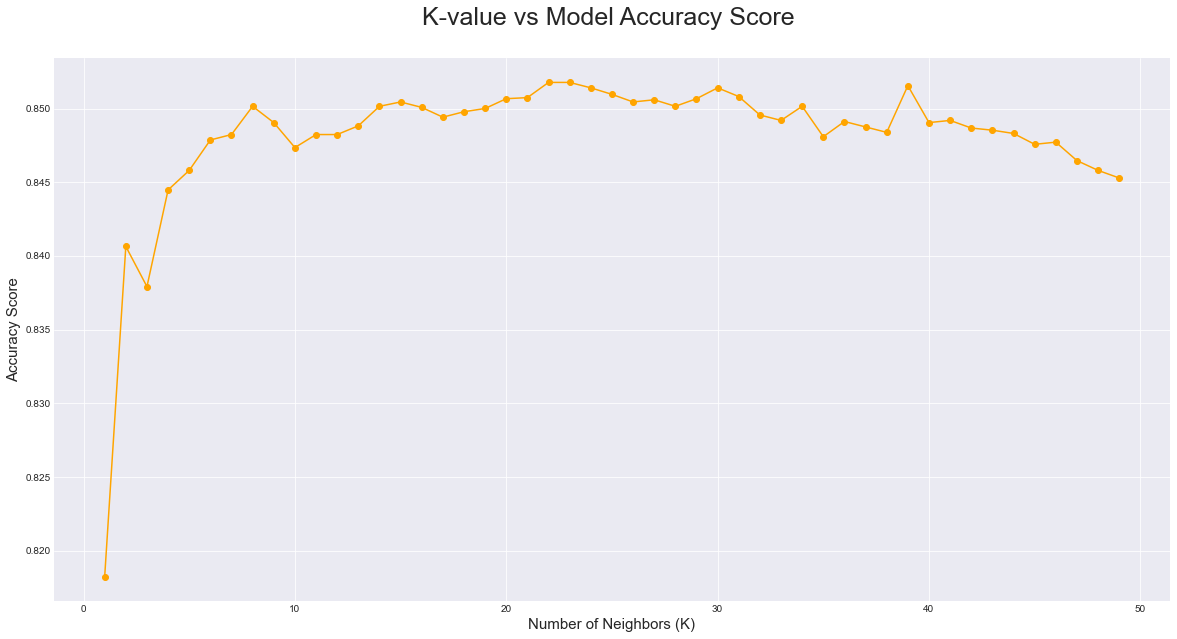

In [75]:
plt.plot(range(1,num_K),mean_score,'orange',marker='o')
plt.ylabel('Accuracy Score', size=15)
plt.xlabel('Number of Neighbors (K)', size=15)
plt.title('K-value vs Model Accuracy Score \n', size=25)
plt.show()

>**From both the list of accuracy scores, and the graph, I have the confident in saying that with a K-value (number of neighbor) being either 22 (or 23) provides us with the most accurate model for the given selected features. And this could be proved by re-running the model with the desire K-value, which in this case is 22.**

In [76]:
KNN_model_final = KNeighborsClassifier(n_neighbors=22).fit(key_train,target_train)
target_pred = KNN_model_final.predict(key_test)
metrics.accuracy_score(target_test,target_pred)

0.8517726837178448

# Key Learning Points

#### Significance of features and variables: 

I've explore the significance of each variables in the section of "Check Correlation Between Each Feature and the Income". Where I split the original census dataset into a numerical only data set, and a catagorical only data set. Also since it's quite complicated to firgure out the correlation between catagorical variables and numerical variable (our target feature income), so I have created dummy variables for all catagorical variables. And from there, I then plotted a correlation heatmap for each set respectively. 

The results shows that all numerical variables are all pretty significant, with the most effective feature being the educational years, and followed by age. Most of the catagorical variables are quite insignificant, although there are still some sub-features from marital status, relationship, and occupation. Married-civ-spouse being the most significant catagorical variable is holding a even stronger correlation with the income than educational years. And followed that is for being a husband. There are two features in the catagorical class are negatively related to income. 

#### How each variables explain the scenario of our case:

Numerical Variables:
> 1) Educational Years - Positively related to income with a correlation ceoffecient of 0.33 (relatively high)
>
> 2) Age - Positively related to income with a correlation ceoffecient of 0.24 (relatively moderate)
>
> 3) Work Hours Per Week - Positively related to income with a correlation ceoffecient of 0.23 (relatively moderate)
>
> 4) Capital Gain - Positively related to income with a correlation ceoffecient of 0.22 (relatively moderate)
>
> 5) Gender - Positively related to income with a correlation ceoffecient of 0.22 (relatively moderate)
>
> 6) Capitcal Loss - Positively related to income with a correlation ceoffecient of 0.15 (relatively low)

Catagorical Variables:
> 1) Married civ Spouse - Positively related to income with a correlation ceoffecient of 0.45 (relatively high)
>
> 2) Husband - Positively related to income with a correlation ceoffecient of 0.4 (relatively high)
>
> 3) Never Married - NEGATIVELY related to income with a correlation ceoffecient of 0.32 (relatively high)
>                  
>     (This means that people who have never married before tend to have lower income than those who did)
>
> 4) Own Child - NEGATIVELY related to income with a correlation ceoffecient of 0.22 (relatively moderate)
>
>     (This means that people who have at leat one child tend to have lower income than those who don't have)
>
> 5) Executive Manager - Positively related to income with a correlation ceoffecient of 0.21 (relatively moderate)


#### Determination of K, and reason for choosing this final value of K:

In the last section of my script, I had set up an algorithm to use 50 different values of K (from 1 to 50) to run the model. And then comparing the accuracy results of each model by both displaying numeric values of each number, and also plotting out a connected scatter plot of the accuracy scores of each.

Both results are showing that the model is performance the best and is most accurate when number of neighbor (K-value) is set to 22 or 23 (both have exactly the same output). Therefore I have choosen K=22 for my final model. The graph also tells us a bit more, the model is very inefficient at k=1, and it starting to get more accurate as the k-value goes up, and when the k-vlue reached to a certain point, the accuracy started to drop again. And in this case that sweet spot is 22.

#### Overall accuracy of the model and accompanying models:

I have had three models developed in total through the exploration, they are:

> Model 1: with only the numerical variables, K=5. This has an accuracy score of 0.8267, so 82.67%.
>
> Model 2: with both numerical and some catagorical variables, K=5. This has an accuracy score of 0.8458, so 84.58%
>
> Model 3: with both numerical and some catagorical variables, K=22. This has an accuracy score of 0.8518, so 85.18%

Each model has been improved a little bit than the previous one, and Model 3 here is my final model which included all the signicifant variables, and also has the most optimal K-value. The 85.18% accuracy also looks like a decent and promising score. 